# This notebook 
## 1) reads and processes .mat files from Graf 2011
## 2) computes spike counts per trial
## 3) plots tuning curves
## 4) builds a Poisson Independent Decoder (PID)
## 5) builds an L1 regularized multinomial logistic regression model
## 6) builds a Bayesian hierarchical logistic regression model 
## 7) evaluates the three models

In [1]:
#!/usr/bin/env python
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [291]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn import *
from edward.models import Bernoulli, Multinomial, Normal, PointMass, MultivariateNormalDiag, MultivariateNormalFullCovariance, MultivariateNormalTriL

In [3]:
tf.__version__

'1.2.1'

In [4]:
ed.set_seed(42)

In [5]:
def read_data(file_path):
    '''Read and process mat file from Graf2011
    
    param array_number: {1, 2, 3, 4, 5}

    return:
        spike_times: {Nx3600} N simultaneously recorded spike trains for 3600 trials
            (50 repeated trials of 72 direction in random order)
        orientation_per_trial: orientation for each trial (of length 3600)
        num_neurons: number of neurons
        orientations: sorted set of orientations
        num_repeats: number of repeats for each (orientation,neuron) (=50)
        num_trials: 50 repeated trials x 72 directions
        trial_length: length of trial (in seconds)
    '''
    dataStruct = scipy.io.loadmat(file_path)
    spike_times = pd.DataFrame.from_dict(dataStruct['spk_times'])
    orientation_per_trial = dataStruct['ori'][0]
    num_neurons = np.shape(dataStruct['neur_param'])[0]
    orientations = np.sort(np.unique(dataStruct['ori']))
    trial_length = 2560e-3
    num_repeats = 50
    num_trials = 3600 # 50 repeated trials x 72 directions
    num_orientations = len(orientations)
    return spike_times, orientation_per_trial, num_neurons, orientations, trial_length, num_repeats, num_trials, num_orientations

In [6]:
def compute_spike_counts(spike_times, num_neurons, num_trials):
    '''
        Compute spike counts for each (orientation, neuron, trial)
        return 3D numpy array: orientation x trials x neurons
        
        TODO: add option to average [0 180] with responses from [180 360]
    '''
    spike_times_mat = spike_times.as_matrix()
    spike_counts = np.zeros((num_orientations, num_neurons, num_repeats))
    # for each orientation
    for i in range(num_orientations):
        # access indices in spike times that corresponds to ori
        idx = np.where(orientation_per_trial == orientations[i])[0]
        spike_times_ori = np.take(spike_times_mat, idx, axis = 1)
        for j in range(num_neurons):
            for k in range(num_repeats):
                spike_counts[i, j, k] = np.count_nonzero(spike_times_ori[j][k])
    return spike_counts

In [7]:
'''
Filters to data
1) spike counts observed after 1280 ms
    - exclude
    - use to filter neurons that do not have a significantly higher mean tc with stimulus than without

2) from paper, 
To get visually driven neurons, we only accepted neurons of which the
peak or trough of their tuning curve fell outside of the window defined
by the mean and one s.d. of their spontaneous activity. Furthermore, we
obtained meaningful sample of V1 neurons by only considering neurons with
tuning curves that could be well approximated (r2   0.75) by bimodal
circular Gaussian functions (the sum of two von Mises functions with
different preferred orientations, amplitudes and bandwidths), allowing us
to accommo- date for direction (mono-modal) or orientation (bi-modal)
tuning. We obtained populations of simultaneously recorded neurons of
sizes 40, 57, 60, 70 and 74. Each data set was obtained in a ~3-h-long
recording session.

3) average across 180 degree axis?

4) if max of tc for neuron i across orientations - min of tc for neuron i across orientations is 
    not greater than 10, -> exclude neuron
    
5) divisive normalization

'''

def normalize_spike_counts(spike_counts, num_orientations, num_neurons, num_repeats):
    '''
        Normalize by variance of spike counts
            for each trial
                square spike counts across (neurons, orientations) then sum across neurons
                divide the square of each spike count by the summed squared spike counts across neurons
                
        PROBLEM: mean tuning curve gives same mean for all entries
    '''
    spike_counts_norm = np.zeros((num_orientations, num_neurons, num_repeats))
    for i in range(num_repeats):
        variance_sum = np.sum(spike_counts[:, :, i]**2, axis = 1).reshape(-1,1)
        spike_counts_norm[:, :, i] = (spike_counts[:, :, i]**2) / np.tile(variance_sum, num_neurons)
    return spike_counts_norm

From Graf 2011, "Evoked activity was estimated over the full stimulus presentation. We neglected the contamination by the blank preceding each grating because this period of the response (the first ~60 ms corresponding to typical V1 response latencies50) was of negligible duration compared with the 1,280 ms stimulus presentation time and this contamination was the same for each grating. Spontaneous activity was assessed on the last 500 ms of each blank presentation to avoid contamina- tion induced by the preceding grating. To get visually driven neurons, we only accepted neurons of which the peak or trough of their tuning curve fell outside of the window defined by the mean and one s.d. of their spontaneous activity. Furthermore, we obtained meaningful sample of V1 neurons by only considering neurons with tuning curves that could be well approximated (r2   0.75) by bimodal circular Gaussian functions (the sum of two von Mises functions with different preferred orientations, amplitudes and bandwidths), allowing us to accommo- date for direction (mono-modal) or orientation (bi-modal) tuning."



From Montijn 2014, "To further parameterize neuronal orientation tuning, we also calculated each neuron's preferred direction by fitting a double von Mises distribution to the neuron's responses, where the peaks of both von Mises functions are opposite to each other (separated by 180°):

$$f(x∣∣θ,κ1,κ2,μ0)= \frac{e^{κ_1cos(x−θ)}}{2πI_0(κ_1)} + \frac{e^{κ_2cos(x+π−θ)}}{2πI_0(κ_2)}+μ_0$$
(1)
Here, I0(κ) is the modified Bessel function of order 0 and x represents the stimulus angle. As can be seen in the equation, we defined the free parameters as θ (preferred direction), κ1 (concentration parameter at θ), κ2 (concentration parameter at θ +π) and μ0 (baseline response). A neuron's preferred direction was defined as the angle with the highest concentration parameter (which could be either κ1 or κ2)."

## is this based on training data or all?

In [1144]:
def compute_mean_tc(spike_counts):
    return np.mean(spike_counts, axis=2)

def compute_var_tc(spike_counts):
    return np.var(spike_counts, axis=2)

def compute_cov_tc(spike_counts):
    tc_cov = np.zeros((num_neurons, num_neurons, num_orientations))
    for i in range(num_orientations):
        tc_cov[:, :, i] = np.cov(spike_counts[i])
    return tc_cov

In [1145]:
def compute_preferred_orientation(mean_tc, num_neurons):
    '''max of tuning curve across orientations'''
    pref_ori = np.zeros(147)
    for i in range(num_neurons):
        pref_ori[i] = np.argmax(mean_tc[:,i])
    return pref_ori

In [1146]:
plt.plot(pref_ori)

NameError: name 'pref_ori' is not defined

In [1136]:
def filter_to_well_tuned_neurons(mean_tc, thresh):
    '''Filter to well tuned neurons, example thresh = 10'''
    maxdiff = np.max(mean_tc, axis=0) - np.min(mean_tc, axis=0)
    ind_tuned = np.where(maxdiff > thresh)[0]
    return ind_tuned

In [1147]:
# path to mat file from Graf 2011
file_path = '../../data/graf_V1data/array_2.mat'

# read and process data
spike_times, orientation_per_trial, num_neurons, orientations, trial_length,\
    num_repeats, num_trials, num_orientations = read_data(file_path)

# compute spike counts
spike_counts = compute_spike_counts(spike_times, num_neurons, num_trials)

# compute tuning curves
mean_tc = compute_mean_tc(spike_counts)
var_tc = compute_var_tc(spike_counts)
cov_tc = compute_cov_tc(spike_counts)

# identify indices for well-tuned neurons
ind_well_tuned = filter_to_well_tuned_neurons(mean_tc, 10)

# normalize spike counts
spike_counts_norm = normalize_spike_counts(spike_counts, num_orientations, num_neurons, num_repeats)

# compute normalized tuning curves
mean_tc_norm = compute_mean_tc(spike_counts_norm)
var_tc_norm = compute_var_tc(spike_counts_norm)
cov_tc_norm = compute_cov_tc(spike_counts_norm)

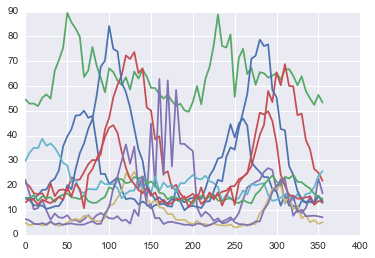

In [1160]:
# plot mean tuning curve for 10 well tuned neurons
%matplotlib inline
sns.set_style("darkgrid")
plt.plot(orientations, mean_tc[:, ind_well_tuned[0:10]]);

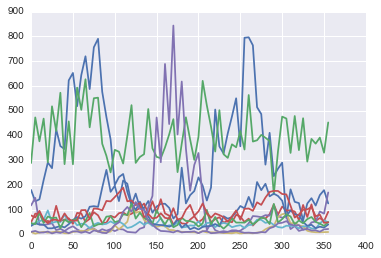

In [1161]:
# plot variance tuning curve for 10 well tuned neurons
plt.plot(orientations, var_tc[:, ind_well_tuned[0:10]]);

### Lets build a Poisson Independent Decoder (PID). We assume each neuron's stimulus-specific spike counts is Poisson distributed and statistically independent across neurons. The rate parameter $w_i(\theta)$ is the logarithm of the mean neuronal tuning function for neuron i across trials for stimulus $\theta$.

### The likelihood function is $\log L(\theta) = \sum_{i=1}^N w_i(\theta)r_i + b(\theta)$. The offset b incorporates overall bias in coverage of orientations and is the sum of the mean tuning curve across neurons for stimulus $\theta$.

In [1059]:
def compute_mean_tc_training(x):
    '''compute mean tuning curve (mean of samples for a given orientation,neuron) given training data (orientation,samples) x neurons'''
    mean_tc = np.zeros((x.shape[0], x.shape[2]))
    for i in range(72):
        mean_tc[i] = np.mean(x[i], axis = 0)
    return mean_tc

In [1269]:
# filter to well-tuned neurons then rotate axes so we have ori x samples x neurons
spike_counts_filt = np.rollaxis(np.rollaxis(spike_counts[:, ind_well_tuned, :], 2), 1)
# train/test split
inds = np.arange(50)
train_ind = np.random.choice(inds, size = 35, replace = False)
test_ind =  np.array([x for x in inds if x not in train_ind])
x_train, x_test = spike_counts_filt[:, train_ind, :], spike_counts_filt[:, test_ind, :]

# compute mean training curve on training data
mean_tc_train = compute_mean_tc_training(x_train)
# weights are log of mean tuning curve
w = np.log(mean_tc_train)
b = np.sum(w, axis=1)

In [1270]:
def likelihood(w_i, r_i, b_i):
    '''Compute data likelihood given w, r, b for stimulus i'''
    return np.log(np.sum(np.dot(w_i, r_i.T)) + b_i)

In [1271]:
def plot_likelihood(w, x_train, b, stimulus_choice):
    '''plot likelihood of stimulus-specific spike train as a function of model choice'''
    sx = []
    for i in range(72):
        sx.append(likelihood(w[i], x_train[stimulus_choice], b[i]))
    fig = plt.plot(sx)

In [1272]:
def likelihood_ratio_test(w, x_train, b, ori1, ori2):
    '''given a population response, compute likelihood ratio test comparing two orientation models'''
    val = likelihood(w[ori1], x_train, b[ori1]) - likelihood(w[ori2], x_train, b[ori2])
    if val > 0:
        return ori1
    else:
        return ori2

In [1273]:
x_train.shape

(72, 35, 58)

In [1274]:
likelihood_ratio_test(w, x_train[10], b, 40,10)

10

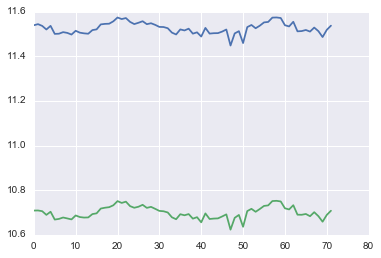

In [1275]:
# likelihood comparison -- which model provides best explanation of the data?,
plot_likelihood(w, x_train, b, 1) # for example, we fit spike trains from ori 1 against all possible models
plot_likelihood(w, x_test, b, 1)

In [1076]:
# write a few evaluation metrics
# compute max of log likelihood use that orientation as "prediction"

### Lets build a L1 regularized multinomial multi-class logistic regression model

In [26]:
# specify model
lr = sklearn.linear_model.LogisticRegression(penalty='l1', fit_intercept=True)

# fit the model
lr.fit(x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2]), y_train)

# predict labels and probability distributions on test data
labels_test = lr.predict(x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2]))
scores_test = lr.predict_proba(x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2]))

In [27]:
def evaluate_one_versus_all(y_test, scores):
    '''AUC scores for one versus all classification on test data across all classes'''
    aucs = []
    for j in range(72):
        sx = []
        for i in range(len(y_test)):
            if y_test[i] == (j+1):
                sx.append(int(1))
            else:
                sx.append(int(0))
        aucs.append(sklearn.metrics.roc_auc_score(np.array(sx),scores[:,j]))
    plt.figure(figsize=(10,5))
    plt.scatter(np.arange(72),aucs)
    plt.xlabel('class')
    plt.ylabel('auc')

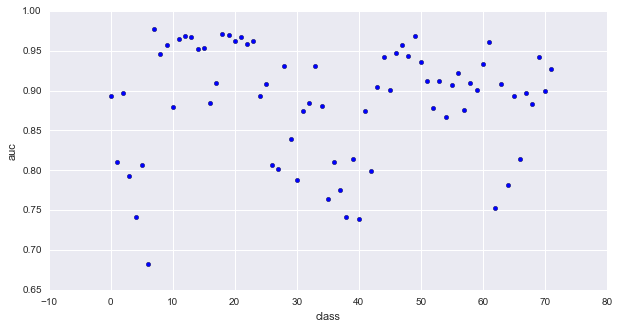

In [28]:
evaluate_one_versus_all(y_test, scores_test)

In [29]:
def evaluate_one_versus_one(y_test, scores, delta):
    '''AUC scores for one class versus one class on test data across all classes
        delta, int : discriminate between class and class + delta    
    '''
    aucs = []
    for j in range(1,73):
        inds = np.concatenate((np.where(y_test == (j))[0], np.where(y_test == (((j-1)+delta) % 72) + 1)[0]))
        #print(y_test[inds])
        #print(scores[inds,j-1])
        y = (y_test[inds] == j).astype(int)
        aucs.append((sklearn.metrics.roc_auc_score(y, scores[inds,j-1])))
    plt.figure(figsize=(10,5))
    plt.scatter(np.arange(72),aucs)
    plt.xlabel('class')
    plt.ylabel('auc')

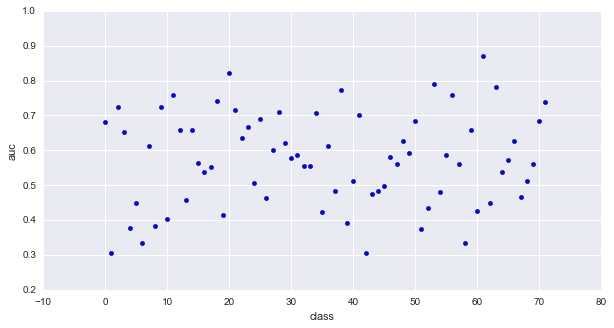

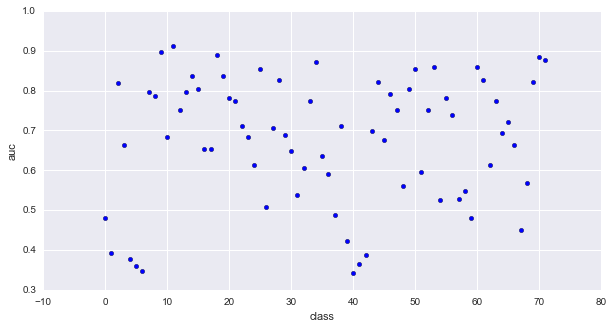

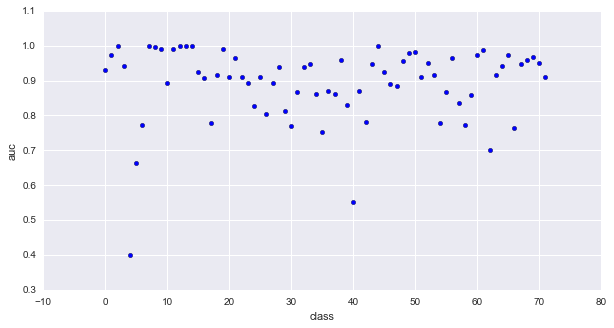

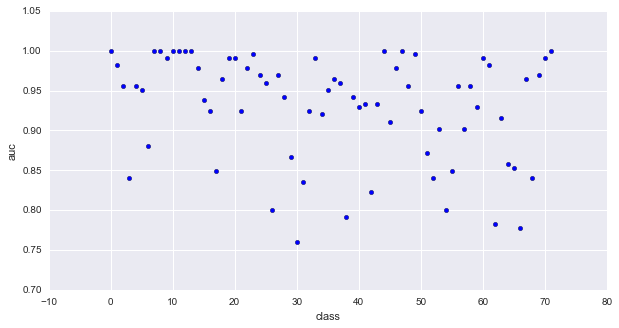

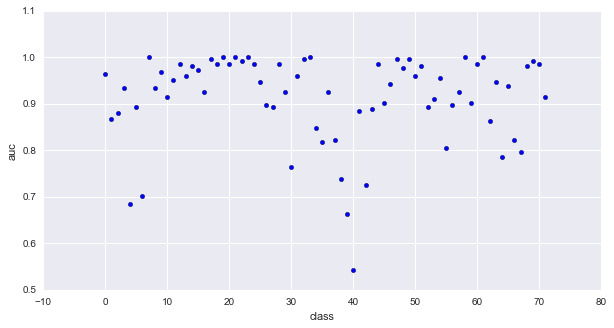

In [30]:
evaluate_one_versus_one(y_test, scores_test, 1)
evaluate_one_versus_one(y_test, scores_test, 2)
evaluate_one_versus_one(y_test, scores_test, 5)
evaluate_one_versus_one(y_test, scores_test, 10)
evaluate_one_versus_one(y_test, scores_test, 20)

## Takeaway: model does poorly at discriminating between orientations 5 degrees a part (consistent with paper) and does better aas delta increases

### Lets build a Bayesian multinomial multi-class logistic regression model
$$p(\theta^{(i)} = c | r^{(i)}, w^{(c)}) = \frac{\exp{(w^{(c)T}r^{(i)})}}{\sum_{j=1}^C(w^{(j)T}r^{(i)})}$$
$$p(w^{(c)}|\Lambda^{(c)}) = \mathcal{N}(0, \Lambda^{(c)}), \Lambda^{(c)} \in \mathcal{R^{\text{NxN}}}$$

In [998]:
# BUILD DATASET where we combine ori's 1,2,3 and 30, 31, 32
inds = np.ravel(np.concatenate((np.where(y_train == 1), np.where(y_train==2), np.where(y_train==3),
                                np.where(y_train==4), np.where(y_train==5), np.where(y_train==6))))
Ytrain = y_train[inds]
Xtrain = np.concatenate((x_train[0], x_train[1], x_train[2], x_train[3], x_train[4], x_train[5]))
N,D = Xtrain.shape

for i in range(len(Ytrain)):
    if (Ytrain[i] == 1) or (Ytrain[i] == 2) or (Ytrain[i]==[3]):
        Ytrain[i] = 0
    else:
        Ytrain[i] = 1

inds = np.ravel(np.concatenate((np.where(y_test == 1), np.where(y_test==2), np.where(y_test==3),
                                np.where(y_test==4), np.where(y_test==5), np.where(y_test==6))))
Ytest = y_test[inds]
Xtest = np.concatenate((x_test[0], x_test[1], x_test[2], x_test[3], x_test[4], x_test[5]))

for i in range(len(Ytest)):
    if (Ytest[i] == 1) or (Ytest[i] == 2) or (Ytest[i]==[3]):
        Ytest[i] = 0
    else:
        Ytest[i] = 1

#N,D = Xtest.shape

In [996]:
Xtrain = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])
Ytrain = []
for i in range(len(y_train)):
    if y_train[i] == 0:
        Ytrain[i] = 0
    elif y_train[i] == 1:
        Ytrain[i] = 1
    elif y_train[i] == 2:
        Ytrain[i] = 2
    else:
        continue

Xtest = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])
Ytest = np.zeros(y_test.shape[0])
for i in range(len(y_test)):
    if y_test[i] == 0:
        Ytest[i] = 0
    elif y_test[i] == 1:
        Ytest[i] = 1
    elif y_test[i] == 2:
        Ytest[i] = 2
    else:
        continue

IndexError: list assignment index out of range

## Set variance across neurons; MAP estimation
$$p(y | x, w)$$
$$p(w | 0, \sigma I)$$

In [1002]:
# MODEL
N,D = Xtrain.shape[0], Xtrain.shape[1]
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale= tf.ones(D))
b = Normal(loc=tf.zeros([]), scale=3.0 * tf.ones([]))
y = Bernoulli(logits=ed.dot(X, w) + b)

# specify approximating family
qw = PointMass(params=tf.Variable(tf.random_normal([D])))
qb = PointMass(params=tf.Variable(tf.random_normal([])))

# do inference
inference = ed.MAP({w: qw, b: qb}, data={X: Xtrain, y: Ytrain})
inference.run()

# EVALUATION
y_post = ed.copy(y, {w: qw.mean(), b: qb.mean()})
print("Classification accuracy on train"),
print(ed.evaluate('binary_accuracy', data={y_post: Ytrain, X: Xtrain}))
scores = y_post.mean().eval({X: Xtrain})
print("AUC score on train", sklearn.metrics.roc_auc_score(Ytrain, scores))

X = tf.placeholder(tf.float32, [Xtest.shape[0], D])
y_post = Bernoulli(logits=ed.dot(X, qw) + qb)
print("Classification accuracy on test"),
print(ed.evaluate('binary_accuracy', data={y_post: Ytest, X: Xtest}))
scores = y_post.mean().eval({X: Xtest})
print("AUC score on test", sklearn.metrics.roc_auc_score(Ytest, scores))

1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | Loss: 98.839
Classification accuracy on train
0.819048
AUC score on train 0.890430839002
Classification accuracy on test
0.7
AUC score on test 0.755555555556


### Optimize variance $\sigma_i$ for each neuron; Variational EM to compute posterior over latent variables and point estimates of model parameters

In [270]:
# MODEL
N, D = Xtrain.shape[0], Xtrain.shape[1]
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc= tf.zeros(D), scale = tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
b = Normal(loc=tf.zeros([]), scale=1.0 * tf.ones([]))
y = Bernoulli(logits=ed.dot(X, w) + b)

# specify approximating family
qw = Normal(loc=tf.Variable(tf.random_normal([D])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([]))))

# do inference
inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain, y: Ytrain})
inference.run(n_iter=1000)


# EVALUATION
y_post = ed.copy(y, {w: qw.mean(), b: qb.mean()})
print("Classification accuracy on train"),
print(ed.evaluate('binary_accuracy', data={y_post: Ytrain, X: Xtrain}))
scores = y_post.mean().eval({X: Xtrain})
print("AUC score on train", sklearn.metrics.roc_auc_score(Ytrain, scores))

X = tf.placeholder(tf.float32, [Xtest.shape[0], D])
y_post = Bernoulli(logits=ed.dot(X, qw) + qb)
print("Classification accuracy on test"),
print(ed.evaluate('binary_accuracy', data={y_post: Ytest, X: Xtest}))
scores = y_post.mean().eval({X: Xtest})
print("AUC score on test", sklearn.metrics.roc_auc_score(Ytest, scores))

1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | Loss: 258.989
Classification accuracy on train
0.982937
AUC score on train 0.81345214142
Classification accuracy on test
0.984259
AUC score on test 0.839749608764


### Optimize full covariance $\Sigma \in \mathcal{R}^{kxk}$ describing correlations between neurons; Variational EM to compute posterior over latent variables and point estimates of  model parameters.

In [271]:
# MODEL
N, D = Xtrain.shape[0], Xtrain.shape[1]


covar = np.zeros((14,14))
covar.fill(.5), np.fill_diagonal(covar, 1)
covar = covar.astype(np.float32)

X = tf.placeholder(tf.float32, [N, D])
w = MultivariateNormalTriL(loc= tf.zeros(D), scale_tril = tf.Variable(tf.cholesky(tf.stack(covar)),name="cov"))
b = Normal(loc=tf.zeros([]), scale=1.0 * tf.ones([]))
y = Bernoulli(logits=ed.dot(X, w) + b)

# specify approximating family
qw = Normal(loc=tf.Variable(tf.random_normal([D])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([]))))

# do inference
inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain, y: Ytrain})
inference.run(n_iter=1000)


# EVALUATION
y_post = ed.copy(y, {w: qw.mean(), b: qb.mean()})
print("Classification accuracy on train"),
print(ed.evaluate('binary_accuracy', data={y_post: Ytrain, X: Xtrain}))
scores = y_post.mean().eval({X: Xtrain})
print("AUC score on train", sklearn.metrics.roc_auc_score(Ytrain, scores))


X = tf.placeholder(tf.float32, [Xtest.shape[0], D])
y_post = Bernoulli(logits=ed.dot(X, qw) + qb)
print("Classification accuracy on test"),
print(ed.evaluate('binary_accuracy', data={y_post: Ytest, X: Xtest}))
scores = y_post.mean().eval({X: Xtest})
print("AUC score on test", sklearn.metrics.roc_auc_score(Ytest, scores))


1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 362.301
Classification accuracy on train
0.986111
AUC score on train 0.757499281403
Classification accuracy on test
0.986111
AUC score on test 0.796369327074


In [1030]:
x_train.shape, y_train.shape

((72, 35, 1), (2520,))

### Extend to multi-class setting - currently unstable - posterior predictive gives different results each time its computed and predictions with posterior predictive are unnormalized

In [1017]:
# MODEL
N,D = Xtrain_list[0].shape[0] * len(Xtrain_list), Xtrain_list[0].shape[1]
C = 3
X = tf.placeholder(tf.float32, [N,D])
w = Normal(loc=tf.zeros((D,C)), scale = 3.0 * tf.ones((D,C)))
#b = Normal(loc=tf.zeros((C)), scale = 3.0 * tf.ones((C)))

# we take the softmax of X^T * w (which is the logit) to get probabilities
y = Multinomial(probs = tf.nn.softmax(tf.matmul(X,w)), total_count = 105.0)

# specify approximating family
qw = Normal(loc=tf.Variable(tf.random_normal([D,C])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([D,C]))))
qb = Normal(loc=tf.Variable(tf.random_normal([C])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([C]))))
#qw = PointMass(params=tf.Variable(tf.random_normal([])))


# do inference
inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain_norm, y: Ytrain_mult})
inference.run()

TypeError: Key-value pair in latent_vars does not have same shape: (), (3,)